In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.onnx
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from tqdm import tqdm

In [2]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation
columns_rearranged = ['image', 'NV', 'MEL', 'BCC', 'AKIEC', 'DF', 'VASC']

skin_cancer_df = pd.read_csv('/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv')
skin_cancer_df.drop(columns=['BKL'], inplace=True)
skin_cancer_df = skin_cancer_df[columns_rearranged]

skin_cancer_2019_df = pd.read_csv('/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv')
skin_cancer_2019_df.drop(columns=['BKL', 'SCC', 'UNK'], inplace=True)
skin_cancer_2019_df.rename(columns={'AK': 'AKIEC'}, inplace=True)
skin_cancer_2019_df = skin_cancer_2019_df[columns_rearranged]


Using device: cuda


In [3]:
multiclass_categories = {
    0: 'NV',
    1: 'MEL',
    2: 'BCC',
    3: 'AKIEC',
    4: 'DF',
    5: 'VASC'
}

filenames_list, multiclass_categories_list = [], []

base_paths = [
    ("/kaggle/input/ham1000-segmentation-and-classification/images", skin_cancer_df),
    ("/kaggle/input/melanoma/DermMel/", [['test', 'valid'], ['NotMelanoma', 'Melanoma']]),
    ("/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input", skin_cancer_2019_df)
]



In [4]:
for base_path, database in base_paths:
    if isinstance(database, pd.DataFrame):
        for row in database.itertuples(index=False):
            filename = os.path.join(base_path, row[0]) + '.jpg'
            filenames_list.append(filename)
            multiclass_index = np.argmax(row[1:])
            multiclass_categories_list.append(multiclass_index)
    else:
        for sub_directory in database[0]:
            for sub_sub_directory in database[1]:
                final_path = os.path.join(base_path, sub_directory, sub_sub_directory)
                for filename in os.listdir(final_path):
                    filenames_list.append(os.path.join(final_path, filename))
                    if sub_sub_directory in ['nevus', 'NotMelanoma']:
                        multiclass_categories_list.append(0)
                    else:
                        multiclass_categories_list.append(database[1].index(sub_sub_directory))

multiclass_df = pd.DataFrame({"filename": filenames_list, "category": multiclass_categories_list})
multiclass_df = multiclass_df.sample(frac=1).reset_index(drop=True)

multiclass_class_counts = np.bincount(multiclass_categories_list)
multiclass_class_weights = {i: len(multiclass_categories_list) / (2.0 * count) for i, count in enumerate(multiclass_class_counts)}

print(f"Multi-class weights: {multiclass_class_weights}")


Multi-class weights: {0: 0.7723883311508802, 1: 2.3088507121887574, 2: 5.534141256189732, 3: 17.78433835845896, 4: 59.98446327683616, 5: 53.758227848101264}


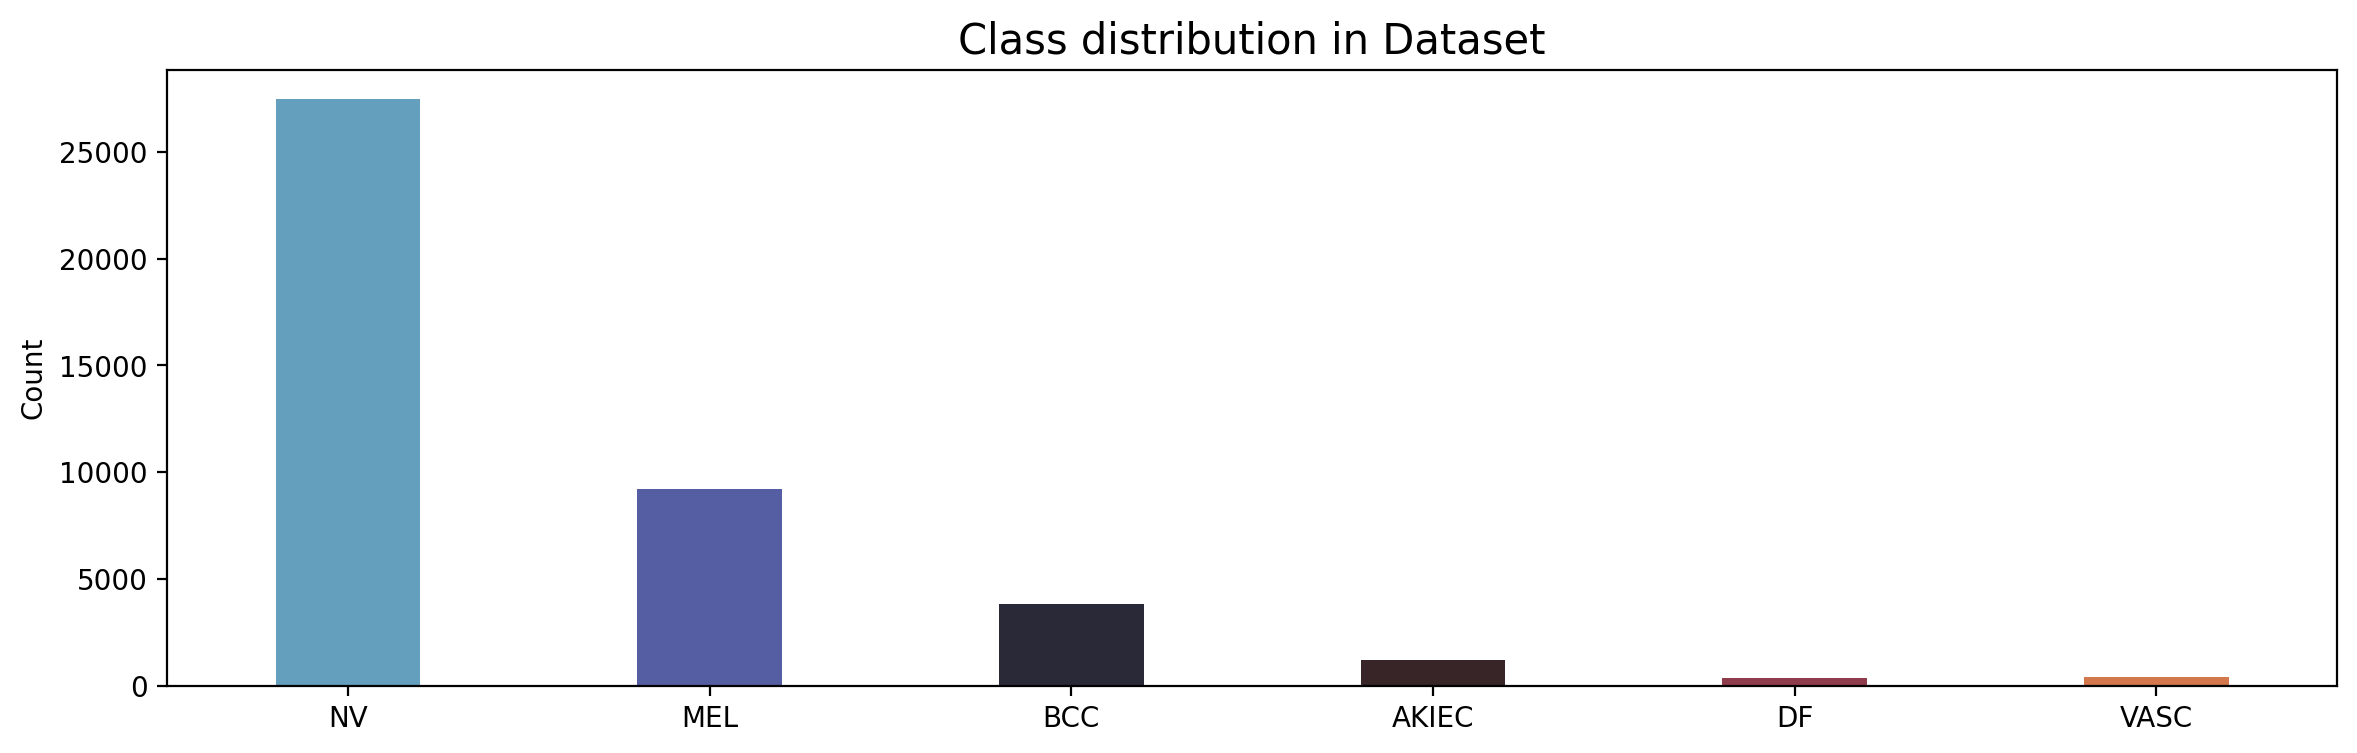

In [5]:
# Visualization
label, count = np.unique(multiclass_df.category, return_counts=True)
uni = pd.DataFrame(data=count, index=multiclass_categories.values(), columns=['Count'])

plt.figure(figsize=(14, 4), dpi=200)
sns.barplot(data=uni, x=uni.index, y='Count', palette='icefire', width=0.4).set_title('Class distribution in Dataset', fontsize=15)
plt.show()

In [6]:
# Train-validation-test split
multiclass_train_df, multiclass_temp_df = train_test_split(multiclass_df, test_size=0.2, stratify=multiclass_df['category'], random_state=42)
multiclass_cv_df, multiclass_test_df = train_test_split(multiclass_temp_df, test_size=0.5, stratify=multiclass_temp_df['category'], random_state=42)


In [7]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = int(self.dataframe.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

image_size = (224, 224)
batch_size = 32

In [8]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = SkinCancerDataset(multiclass_train_df, transform=transform)
val_dataset = SkinCancerDataset(multiclass_cv_df, transform=transform)
test_dataset = SkinCancerDataset(multiclass_test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=14)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=14)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=14)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
class MobileNetV3(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV3, self).__init__()
        self.model = models.mobilenet_v3_small(pretrained=True)
        in_features = self.model.classifier[3].in_features
        self.model.classifier[3] = nn.Linear(in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)  
        return x

model = MobileNetV3(num_classes=len(multiclass_categories))
model = model.cuda()

[torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:01<00:00, 5.76MB/s]


['Tesla P100-PCIE-16GB']

In [10]:
model = MobileNetV3(num_classes=len(multiclass_categories))
device = torch.device("cuda")
model = model.to(device)

# Define the criterion with class weights
class_weights = torch.tensor(list(multiclass_class_weights.values()), dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

num_epochs = 2
early_stopping_patience = 6
best_val_loss = float('inf')
epochs_no_improve = 0




In [11]:
def train_one_epoch(epoch, model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0
    correct_train = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", ncols=100):
        images, labels = images.to(device, dtype=torch.float32), labels.cuda().long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / len(train_loader.dataset)

    return train_loss, train_accuracy

def validate_one_epoch(epoch, model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", ncols=100):
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / len(val_loader.dataset)

    return val_loss, val_accuracy

def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping_patience, device):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(epoch, model, train_loader, optimizer, criterion, device)
        val_loss, val_accuracy = validate_one_epoch(epoch, model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping")
            break
            
train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping_patience, device)


Validation Epoch 1/2: 100%|███████████████████████████████████████| 133/133 [00:23<00:00,  5.73it/s]


Epoch 1/2, Train Loss: 1.4526, Train Accuracy: 0.6350, Validation Loss: 1.3851, Validation Accuracy: 0.6777


Validation Epoch 2/2: 100%|███████████████████████████████████████| 133/133 [00:22<00:00,  5.93it/s]

Epoch 2/2, Train Loss: 1.3740, Train Accuracy: 0.6527, Validation Loss: 1.3867, Validation Accuracy: 0.6911


In [12]:
# Test the model
model.eval()
test_loss = 0.0
correct_test = 0

# Create a dummy input tensor matching the input dimensions of the model
dummy_input = torch.randn(1, 3, 224, 224, device='cuda')  # Example for a model with 3-channel image input

# Export the model
torch.onnx.export(model, dummy_input, "model.onnx", export_params=True, opset_version=10)

predictions = []
true_classes = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing", ncols=100):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_classes.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = correct_test / len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Testing: 100%|████████████████████████████████████████████████████| 133/133 [00:25<00:00,  5.28it/s]

Test Loss: 1.3601
Test Accuracy: 68.73%


In [13]:
# Calculate precision
precision = accuracy_score(true_classes, predictions) * 100
print(f'Precision: {precision:.2f}%')


Precision: 68.73%


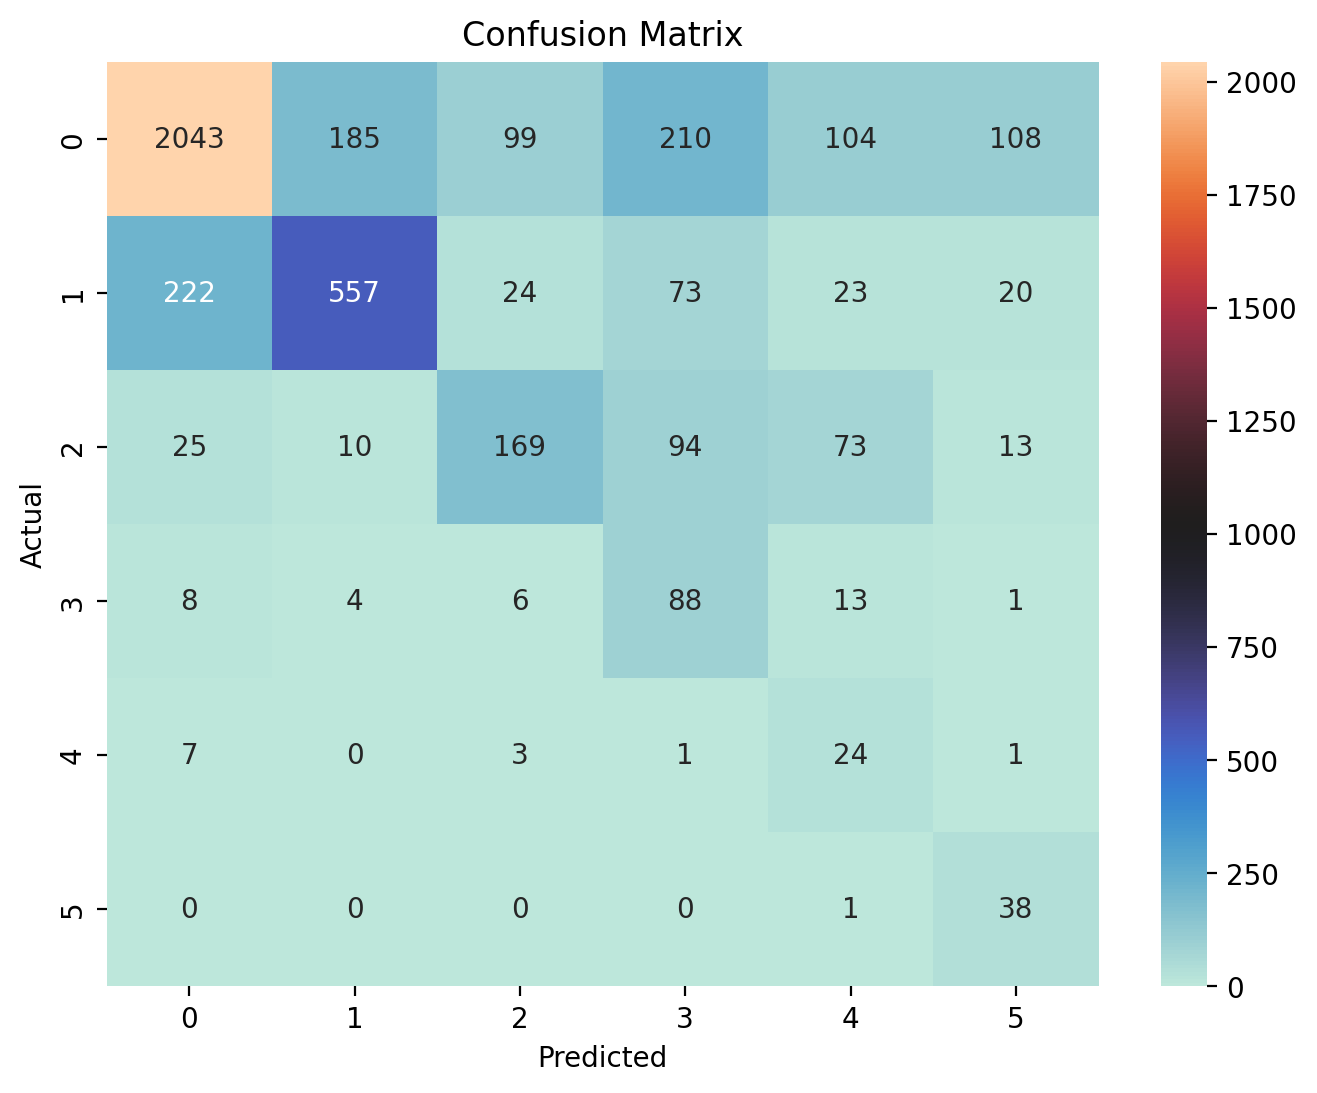

In [14]:
# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predictions)
plt.figure(figsize=(8, 6), dpi=200)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='icefire', xticklabels=multiclass_categories.keys(), yticklabels=multiclass_categories.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()


In [15]:
# Save the model
torch.save(model.state_dict(), 'multiclass_model_final.pth')

# Load an image-label pair from the test dataset
image, label = test_dataset.__getitem__(0)
print(image)

# Ensure the model is in evaluation mode
model.eval()

# If you're using a GPU, you also need to send the image and the model to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
image = image.to(device)  # Send the image to the GPU if you're using one

# Perform the forward pass with no_grad to save memory and compute speed
with torch.no_grad():
    output = model(image.unsqueeze(0))  # Add a batch dimension

# Print the output
print("output: ", output)

# To get the predicted class
predicted_class = torch.argmax(output)
print(f"Predicted class: {predicted_class}")

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1